keras-nightly==2.5.0.dev2021032900 PennyLane==0.17.0 StrawberryFields==0.18.0 tensorflow-2.4.0-cp38-cp38-macosx_10_9_x86_64.whl

In [97]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers

import pennylane as qml

import matplotlib.pyplot as plt
import warnings
import tensorflow as tf


The dataset used is a resampled set from credit card fraudulent trasaction dataset. The resampling was done to have genuine vs fraudulent rate to be 3:1

In [113]:


# ===================================================================================
#                       Data Preparation Function
# ===================================================================================
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# 1,968 samples 
data = pd.read_csv('dos_data.csv')
# Features to use (excluding 'label')
features = ['frame.len', 'wlan.duration', 'wlan.seq', 'data.len', 'wlan.fc.type',
       'frame.protocols', 'llc.type', 'ip.hdr_len', 'ip.len', 'ip.ttl',
       'ip.proto', 'udp.srcport', 'udp.dstport', 'udp.length', 'temperature',
       'battery', 'pitch', 'roll', 'yaw','class']
data = data[features]
def data_prep(data_frame):
    
    if len(data_frame.columns) == 11:
        pass
        
 
    data = data_frame
    shuffled = data.sample(frac=1)      # shuffle data
    features = shuffled.iloc[:, :-1]    # select only the features by dropping the last column
    labels = shuffled.iloc[:, -1]       # select only the labels by selecting the last column
    
    # convert data to numpy array to use train and test split using scikitlearn
    features_np = features.to_numpy(dtype=np.float32)
    features_np =scaler.fit_transform(features_np)
    labels_np = labels.to_numpy(dtype=np.int32)
    

    X_train, X_test, y_train, y_test = train_test_split(features_np, labels_np, test_size=0.2, random_state=42)
        
    return X_train, y_train, X_test, y_test

def one_hot(labels):  
    
    depth = 2
    indices = labels.astype(np.int32)    
    one_hot_labels = np.eye(depth)[indices].astype(np.float32) 
    
    return one_hot_labels

# one-hot encoded labels, each label of length cutoff dimension**2
X_train, Y_train, X_test, Y_test = data_prep(data)
y_train, y_test = one_hot(Y_train), one_hot(Y_test)

# convert them into tensorflow tensors
X_train = tf.convert_to_tensor(X_train)
y_train = tf.convert_to_tensor(y_train)
X_test = tf.convert_to_tensor(X_test)
y_test = tf.convert_to_tensor(y_test)

In [114]:

keras.backend.set_floatx('float32')

hidden = layers.Dense(10, activation="elu")
num_qubits = 5  # Number of qubits in the quantum circuit
out = layers.Dense(num_qubits * 3, activation="elu")  # Adjusted output size for quantum input
clayer_out = layers.Dense(2, activation='softmax')  # Final classical layer for classification

# ===================================================================================
#                                    Quantum Circuit
# ===================================================================================

dev = qml.device("default.qubit", wires=num_qubits)
num_layers = 2  # Number of quantum layers

@qml.qnode(dev, interface="tf", diff_method='backprop')
def quantum_nn(inputs, var):

    for i in range(num_qubits):
        qml.RX(inputs[:, i], wires=i)
        qml.RY(inputs[:, num_qubits + i], wires=i)
        qml.RZ(inputs[:, 2 * num_qubits + i], wires=i)

    # Iterative quantum layers
    for l in range(num_layers): #4
        v = var[l]  # Shape: (num_qubits * 3,)
      

        # Apply parameterized gates
        for i in range(num_qubits):
            qml.RX(v[i], wires=i)
            qml.RY(v[num_qubits + i], wires=i)
            qml.RZ(v[2 * num_qubits + i], wires=i)

        # Entanglement
        for i in range(num_qubits - 1):
            qml.CNOT(wires=[i, i + 1])
        qml.CNOT(wires=[num_qubits - 1, 0])  # Entangle last qubit with the first

    # Measurement
    return [qml.expval(qml.PauliZ(i)) for i in range(num_qubits)]

In [ ]:
# ===================================================================================
#                                    Hybrid Model
# ===================================================================================


def hybrid_model(num_layers, num_qubits):
    weight_shapes = {"var": (num_layers, num_qubits * 3)}
    qlayer = qml.qnn.KerasLayer(quantum_nn, weight_shapes, output_dim=num_qubits)
    hybrid_model = tf.keras.Sequential([hidden, hidden, out, qlayer, clayer_out])
    return hybrid_model

model = hybrid_model(num_layers, num_qubits)


# ===================================================================================
#                                     Training
# ===================================================================================

opt = keras.optimizers.Adam(learning_rate=0.1)

model.compile(opt, loss='categorical_crossentropy', metrics=['accuracy'])
subset_size = 7500

# Randomly select a subset of the training and test data
X_train = X_train[:subset_size]
y_train = np.array(y_train[:subset_size])  # Ensure y_train is a NumPy array

# If needed, reduce the size of the test data as well
X_test = X_test[:subset_size]
y_test = np.array(y_test[:subset_size])  # Ensure y_test is a NumPy array
history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=190,
    shuffle=True,
    validation_data=(X_test, y_test)
)

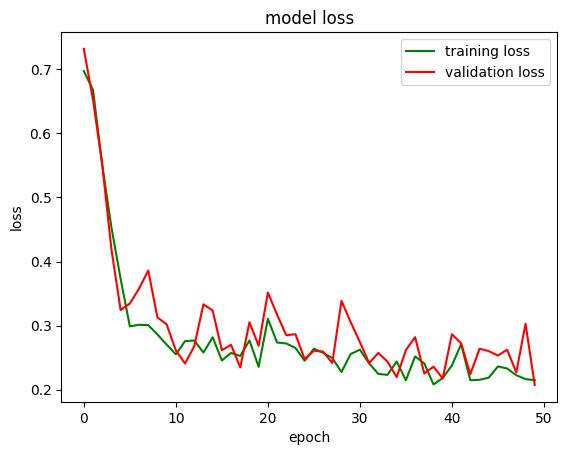

In [111]:
# ===================================================================================
#                                  Loss History Plot
# ===================================================================================

plt.title('model loss')
plt.plot(history.history['loss'], '-g', label = 'training loss')
plt.plot(history.history['val_loss'], '-r', label = 'validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='upper right')
plt.show()

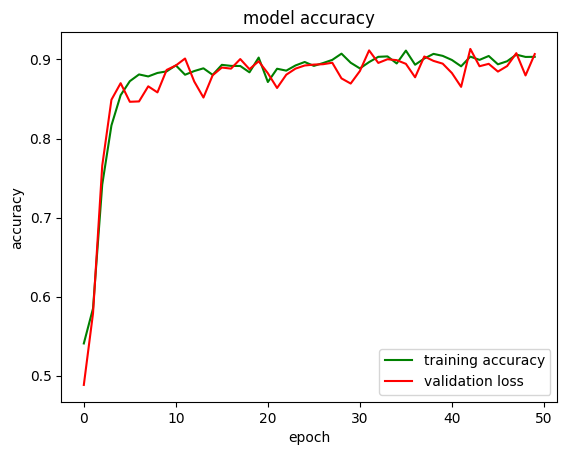

In [112]:
# ===================================================================================
#                                Accuracy History Plot
# ===================================================================================

plt.title('model accuracy')
plt.plot(history.history['accuracy'], '-g', label = 'training accuracy')
plt.plot(history.history['val_accuracy'], '-r', label = 'validation loss')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(loc='lower right')
plt.show()